## 2017 X-class flare observed with GOES-16: HRC shield rate proxy calibration

From Brian Kress (NOAA affiliate):

<blockquote>
The Sept. 2017 GOES-16 SGPS dataset and comparison plots with GOES-13 and -15 EPS/EPEAD are now available under the "Special Event Data" tab on the NOAA-NCEI website.
<br><br>
https://www.ngdc.noaa.gov/stp/satellite/goes-r.html
<br><br>
ftp://ftp.ngdc.noaa.gov/STP/goesr/solar_proton_events/sgps_sep2017_event_data/
<br><br>
A paper describing SGPS measurements, this dataset and applied corrections will be available soon.
</blockquote>

In particular, he verified that
<blockquote>
(...) both G14 and G15 have P5 background rates 0.016-0.019 (p/cm^2-s-sr-MeV), in 2017 to 2020, in the data archived under https://www.ngdc.noaa.gov/stp/satellite/goes/dataaccess.html. Given that G14 and G15 are in agreement in the NCEI data, I expect the lower SWPC G14 backgrounds [that MTA recorded in realtime] are due to some difference in SWPC’s processing of G14 vs. G15, not instrument level differences. My guess is that there was some background subtraction and floor being used on G14, but I’m really not sure of this. Questions about it would have to be directed at SWPC.
</blockquote>

Comment on comparing background levels from different instruments:

<blockquote>
(...) background rates [are] due to GCR counts picked up by the high energy tail ("out-of-band") portion of the response function. The EPEAD (and G16 SGPS) differential channels are designed to measure SEP fluxes with a steep spectrum, not GCRs. The background levels are in general different for different instruments (although we do expect them to be similar for the different EPEADs on G13-G15). Actual GCR fluxes at EPEAD P5 energies are ~10^-5 - 10^-4 (p/cm^2-s-sr-MeV), way below the background level. If we see order of magnitude differences between fluxes reported during, e.g., the Sept. 2017 GLE, then there is some problem, but I would not worry too much about comparing background levels from the different EPEADs and SGPSs.
</blockquote>


__Old HRC proxy__<br>
HRC shield rate proxy computed using GOES data available prior to GOES-16, a linear combination of proton fluxes in three channels:<br>
_OLD HRC PROXY = 6000 x P4 + 270000 x P5 + 100000 x P6_

__GOES-16 HRC proxy__<br>
Proxy computed with the same coefficients as before but using GOES-16 channels P5, P7, P8A:<br>
_GOES-16 HRC PROXY = 6000 x P5 + 270000 x P7 + 100000 x P8A_

__New HRC proxy__<br>
HRC shield rate proxy derived by fitting the September 2017 telemetry (2SHLDART) with a 4-parameter model:<br>
_NEW HRC PROXY = c0 x P5 + c1 x P7 + c2 x P8A + c3_, where P5, P6, P8A are GOES-16 channels proton channels.

### Data sources used in this analysis

  * GOES-16 SGPS data covering the September 2017 flare, "Special Even Data" tab on the NOAA-NCEI website, https://www.ngdc.noaa.gov/stp/satellite/goes-r.html
  * Corresponding GOES 13/15 EPS/EPEAD realtime data archived by the Chandra Team through Replan Central
  * HRC shield rate from the Chandra telemetry archive (MSIDs: 2SHLDART or 2SHLDBRT)
    
### Summary of the main analysis steps

__Cell 10__<br>
The September 2017 flare profiles observed with OLD GOES satellites and GOES-16. Comparison plots can also be found online on NOAA-NCEI website: ftp://ftp.ngdc.noaa.gov/STP/goesr/solar_proton_events/sgps_sep2017_event_data/

__Cell 17__<br>
HRC shield rate telemetry (2SHLDART, September 2017) and the OLD and GOES-16 proxies. One striking difference is a lower noise level in the GOES-16 proxy compared to the OLD proxy.

__Cell 18__<br>
An arbitrary correction applied to the GOES-16 proxy to account for the lower bgd level of GOES 16 as compared to the earlier GOES satellites and the HRC shield.

__Cell 26__<br>
Data preparation: filtering out time intervals corresponding to radiation zone passages, radiation shutdowns and telemetry saturation (occasionnal 2SHLDART vals at the level of 250 counts/sample).

__Cells 29-31__<br>
Fit of the new model to the complete Sept. 2017 telemetry dataset. Fit to the telemetry at the time of the initial flaring period used later (see Cell 35) to predict the HRC shield rate at the time of the main flare. Fit to the telemetry at the time of the main flare used to predict the HRC shield rate at the time of the initial flaring.

__Cell 33__<br>
Fit to the scaled telemetry to demonstrate that the resulting coefficients are broadly in agreement with those resulting from a fit to not scaled telemetry, if corrected by 256.

__Cell 35__<br>
The new model of the HRC shield rate derived based on the GOES-16 observation of the 2017 flare, and model predictions.

__Cell 38__<br>
Application of the new model to the December 2020 HRC shield rate at the time of a C-class flare.

__Cell 43__<br>
Comparison of the old and new proxies as a function of proton flux for various energy channels.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 13})
import matplotlib.pyplot as plt
import tables
from kadi import events
from astropy.time import Time
from Ska.Numpy import interpolate
from Ska.Matplotlib import plot_cxctime
from Ska.engarchive import fetch as fetch
from Chandra.Time import DateTime
from sherpa.astro import ui
from netCDF4 import Dataset as NCDataset

In [2]:
# start and end times for the 2017 flare file
FLARE_START_TIME = '2017-09-01T00:00:00.000'
FLARE_END_TIME = '2017-10-01T00:00:00.000'

# GOES-16 data format constants
RECORDS = 8640
UNITS = 2
CHANNELS = 14
DIFF_CHANNELS = 13

# HRC Proxy (old) coeeficients, AA * P4 + BB * P5 + CC * P6
AA = 6000
BB = 270000
CC = 100000

# nominal channel energies for HRC proxy, pre-G16
CHAN_LABEL_PRE_G16 = ['P4 (15-40 MeV)','P5 (38-82 MeV)','P6 (84-200 MeV)']
CHANS_PRE_G16_PROXY = {0: 'P4', 1: 'P5', 2: 'P6'}

# nominal channel energies, GOES-16
CHAN_LABEL_G16 = ['P1 (1.0-1.9 MeV)', 'P2A (1.9-2.3 MeV)', 'P2B (2.3-3.4 MeV)',\
                  'P3 (3.4-6.5 MeV)', 'P4 (6.5-12 MeV)', 'P5 (12-25 MeV)',\
                  'P6 (25-40 MeV)', 'P7 (40-80 MeV)',\
                  'P8A (83-99 MeV)', 'P8B (99-118 MeV)', 'P8C (118-150 MeV)',\
                  'P9 (150-275 MeV)', 'P10 (275-500 MeV)', 'P11 (>500 MeV)']

# GOES-16 designations of proton channels proposed for the new proxy
CHANS_G16_PROXY = {5: 'P5', 7: 'P7', 8: 'P8A'}

In [3]:
def convert_j2000_to_chandra_time(times):
    t1 = Time('1998-01-01T00:00:00')
    t2 = Time('2000-01-01T12:00:00')
    dt = t2 - t1  # Difference between two Times
    return times + dt.sec


def get_sgps_g16_proton_data(filename):
    """
    read SGPS Sept. 2017 event data
    B. Kress, Jan. 2021
    """
    # arrays for timestamps and fluxes
    TimeStamp = np.zeros([RECORDS], dtype=np.float64)
    ProtonFluxes = np.zeros([RECORDS, UNITS, CHANNELS], dtype=np.float32)

    # open file and read data set
    ds = NCDataset(filename, mode='r' )
    num_records = len(ds.variables['L2_SciData_TimeStamp'][:])
    TimeStamp[0:num_records] = ds.variables['L2_SciData_TimeStamp'][:]
    ProtonFluxes[0:num_records,:,0:DIFF_CHANNELS] = ds.variables['AvgDiffProtonFlux'][:,:,:]
    ProtonFluxes[0:num_records,:,DIFF_CHANNELS] = ds.variables['AvgIntProtonFlux'][:,:]
    ds.close()
    
    return TimeStamp, ProtonFluxes


def get_arc_goes_data():
    # Retrieve GOES data archived through Replan Central (arc)
    h5_file = "/proj/sot/ska/data/arc3/hrc_shield.h5"
    out = {}

    with tables.open_file(h5_file, mode='r',
                          filters=tables.Filters(complevel=5, complib='zlib')) as h5:
        table = h5.root.data

    h5 = tables.open_file(h5_file, mode='r')
    table = h5.root.data
    
    out['sat'] = table.col('satellite')
    out['secs'] = table.col('time')
    out['p1'] = table.col('p1')
    out['p2a'] = table.col('p2a')
    out['p2b'] = table.col('p2b')
    out['p3'] = table.col('p3')
    out['p4'] = table.col('p4')
    out['p5'] = table.col('p5')
    out['p6'] = table.col('p6')
    out['p7'] = table.col('p7')
    out['p8a'] = table.col('p8a')
    out['p8b'] = table.col('p8b')
    out['p8c'] = table.col('p8c')
    out['p9'] = table.col('p9')
    out['hrc_shield'] = table.col('hrc_shield') # scaled by 256
    h5.close()
    
    return out


def calc_HRCProxy(proton_fluxes):
    # AA, BB, CC are the old HRC proxy coefficients
    hrc_proxy = AA * proton_fluxes[0] + BB * proton_fluxes[1] + CC * proton_fluxes[2]
    return hrc_proxy


def plot_format(ax, k):
    plt.yscale('log')
    plt.ylabel('protons/cm$^2$-s-sr-MeV')
    if k == 0:
        textstr = 'SGPS-X (west)'
    elif k == 1:
        textstr = 'SGPS+X (east)'
    ax.text(0.05, 0.97, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top')
    plt.grid()
    plt.legend(loc='upper right', prop={'size': 10})

    
def plot_flare_profiles(k, old_chan, new_chan, color, ylabel=True):
    """
    Compare pre-GOES-16 and GOES-16 channels
    """
    # GOES-16
    plot_cxctime(TimeStamp, ProtonFluxes[:, k, new_chan], alpha=0.7,
                 color=color, label=f'{CHAN_LABEL_G16[new_chan]} GOES-16')
    # GOES-13/15, arc a.k.a. Replan Central
    plot_cxctime(arc_goes['secs'], arc_goes[f'{CHANS_PRE_G16_PROXY[old_chan].lower()}'],
                 color=color, label=CHAN_LABEL_PRE_G16[old_chan],
                 alpha=0.3)
    ax = plt.gca()
    plot_format(ax, k)
    plt.xlim(DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate)
    plt.ylim(8e-5, 300)
    if not ylabel:
        plt.ylabel('')

        
def plot_old_new_proxy(k, arc_time_flt, hrcproxy, hrcproxy_correction, shld_dat):
    
    # GOES-13/15, arc a.k.a. Replan Central
    # already scaled by 256
    plot_cxctime(arc_goes['secs'][arc_time_flt],
                 arc_goes['hrc_shield'][arc_time_flt],
                 color='lightgray', label="OLD GOES proxy")
    # GOES-16
    plot_cxctime(TimeStamp, hrcproxy // 256 + hrcproxy_correction,
                 color='gray', label="GOES-16 proxy")
    # HRC shield rate, Chandra telemetry
    plot_cxctime(shld_dat.times, shld_dat.vals // 256,
                 color='C0', marker='.', ls='None',
                 label=f"2SHLDART (HRC shield telemetry)")
    # Limits
    plt.hlines([80], DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate,
               color='goldenrod', linestyle=(0, (10, 4)))
    plt.hlines([250], DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate,
               color='darkred', linestyle=(0, (10, 4)))

    ax = plt.gca()
    plot_format(ax, k)
    plt.ylabel('2SHLDART // 256')

    
def plot_fit_results(res, conf, proton_fluxes, idx0, idx1, label):
    # OLD/NEW proxy
    plot_cxctime(TimeStamp, HRCProxy_2017 // 256,
                 color='gray', label="Old coeffs, new GOES chans", alpha=0.5)
    
    # HRC shield rate new proxy model (new data, new coefficients)
    model, model_min, model_max = get_model_min_max(res, conf, proton_fluxes)

    ax = plt.gca()
    ax.fill_between(DateTime(TimeStamp).plotdate, model_min // 256, model_max // 256,
                    color='k', label=f'{label}, 1 sigma conf region')

    # HRC shield rate (telemetry)
    plot_cxctime(TimeStamp[okg], shld2017_intrpl // 256,
                 color='lightsteelblue', marker='.', ls='None')    
    # Section with HRC shield rate that was modeled
    plot_cxctime(TimeStamp[okg][idx0:idx1], shld2017_intrpl[idx0:idx1] // 256,
                 color='C0', marker='.', ls='None', 
                 label="2SHLDART (fitted HRC shield telemetry)")
    # MTA limits
    plt.hlines([80], DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate,
               color='goldenrod', linestyle=(0, (10, 4)))
    plt.hlines([250], DateTime(FLARE_START_TIME).plotdate, DateTime(FLARE_END_TIME).plotdate,
               color='darkred', linestyle=(0, (10, 4)))
    plot_format(ax, k)
    plt.ylabel('2SHLDART // 256')
    

def plot_proxy_ratio(proxy_ratio, plot_title):
    for ii, key in enumerate(CHANS_G16_PROXY.keys()):
        plt.plot(ProtonFluxes[:, k, key], proxy_ratio, '.', color=f'C{ii + 1}',
                 linestyle='None', label=f'{CHANS_G16_PROXY[key]} GOES-16', alpha=0.1)
    plt.loglog()
    plt.grid()
    plt.xlabel('protons/cm$^2$-s-sr-MeV')
    plt.ylabel('GOES-16 proxy / OLD GOES proxy')
    plt.legend()
    plt.ylim(3e-2, 4)
    plt.title(plot_title)

## Data

In [4]:
# Input file, GOES-16, Sep 2017
# proton fluxes in units of #/cm2-s-sr-keV
# time in j2000
filename = 'g16-flare/se_sgps-l2-avg5m_g16_s20172440000000_e20172732355000_v2_0_0.nc'
TimeStamp, ProtonFluxes = get_sgps_g16_proton_data(filename)

In [5]:
# Convert the times from j2000 to Chandra time
TimeStamp = convert_j2000_to_chandra_time(TimeStamp)
# Convert flux units from #/cm2-s-sr-keV to #/cm2-s-sr-MeV
ProtonFluxes = ProtonFluxes * 1000

In [6]:
print("Using the following GOES-16 channels for the HRC proxy comparison:")
for key in CHANS_G16_PROXY.keys():
    print(CHAN_LABEL_G16[key])

Using the following GOES-16 channels for the HRC proxy comparison:
P5 (12-25 MeV)
P7 (40-80 MeV)
P8A (83-99 MeV)


In [7]:
# Realtime GOES data archived through Replan Central 
# NOTE: Replan Central contains hrc_shield proxy that is normalized (/ 256)
arc_goes = get_arc_goes_data()

In [8]:
# Time filters for GOES data archived through arc a.k.a Replan Central

# September 2017, X-class flare
arc2017_flt = (arc_goes['hrc_shield'] > 0.1) & \
              (arc_goes['secs'] > DateTime(FLARE_START_TIME).secs) & \
              (arc_goes['secs'] < DateTime(FLARE_END_TIME).secs)

# December 2020, C-class flare
arc2020_flt = (arc_goes['hrc_shield'] > 0.1) & \
              (arc_goes['secs'] > DateTime('2020:329').secs) & \
              (arc_goes['secs'] < DateTime('2020:354').secs)
        
# January 2021, quiet
arc2021_flt = (arc_goes['hrc_shield'] > 0.1) & \
              (arc_goes['secs'] > DateTime('2021:001').secs) &\
              (arc_goes['secs'] < DateTime('2021:031').secs)

# 2017 X-class flare profile seen by different GOES satellites

In [9]:
# SGPS-X (west) unit
k = 0

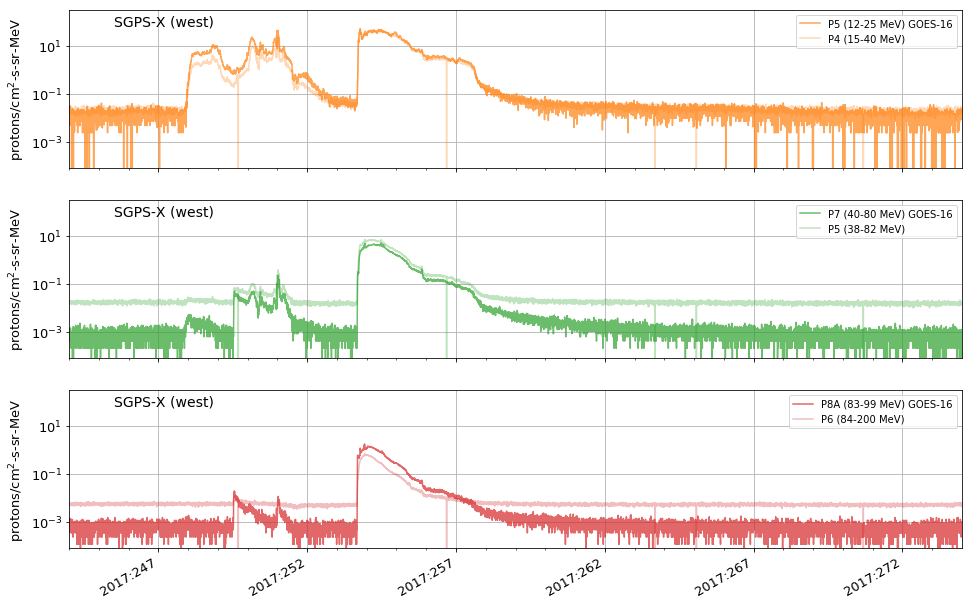

In [10]:
plt.figure(figsize=[16, 11])
for ii in range(3):
    plt.subplot(3, 1, ii + 1)
    plot_flare_profiles(k,
                        list(CHANS_PRE_G16_PROXY.keys())[ii],
                        list(CHANS_G16_PROXY.keys())[ii],
                        f'C{ii + 1}')

__Figure:__ The 2017 strong flare observed with an old generation GOES satellite (Replan Central archive) and a new generation GOES-16 satellite (NOAA website). The "pale" colors represent the three channels on GOES-13/14/15 that were used to compute the HRC shield proxy. The darker colors represent the three GOES-16 channels proposed to replace the old channels. It can be noticed that the background level differs significantly between the old and new GOES instruments (up to > an order of magnitude), and the difference is not constant between the channels. 

Confirming that GOES-16 levels in those three channels before and after the flare are in agreement with the levels observed in Jan 2021:

In [11]:
for key in CHANS_G16_PROXY.keys():
    print(CHAN_LABEL_G16[key],
          # Mean of 100 samples before the 2017 flare
          np.mean(ProtonFluxes[:, k, key][:100]),
          # Mean of 100 samples after the 2017 flare
          np.mean(ProtonFluxes[:, k, key][-100:]),
          # Mean of samples in Jan 2021
          np.mean(arc_goes[CHANS_G16_PROXY[key].lower()][arc2021_flt]))

P5 (12-25 MeV) 0.0129387 0.0121133 0.0119037899315
P7 (40-80 MeV) 0.000790953 0.000711229 0.0017884542648
P8A (83-99 MeV) 0.000662636 0.000611664 0.000811565649103


# HRC shield proxy

In [12]:
# HRC shield rate from the Chandra telemetry archive, 2SHLD(A/B)RT
# Sep 2017, X-class flare
shld2017 = fetch.Msid('2shldart', start=FLARE_START_TIME, stop=FLARE_END_TIME)

In [13]:
okrz = (events.rad_zones.table['tstart'] > DateTime(FLARE_START_TIME).secs) &\
       (events.rad_zones.table['tstop'] < DateTime(FLARE_END_TIME).secs)

In [14]:
events.rad_zones.table[okrz]

start,stop,tstart,tstop,dur,orbit,orbit_num,perigee
str21,str21,float64,float64,float64,int64,int64,str21
2017:245:18:28:23.275,2017:246:09:06:22.229,620764172.459,620816851.413,52678.954,2496,2496,2017:246:01:09:43.782
2017:248:11:03:22.676,2017:249:00:16:57.630,620996671.86,621044286.814,47614.954,2497,2497,2017:248:16:37:16.295
2017:251:01:10:10.909,2017:251:16:09:45.863,621220280.093,621274255.047,53974.9539999,2498,2498,2017:251:08:04:41.115
2017:253:16:41:10.694,2017:254:07:41:09.649,621448939.878,621502938.833,53998.955,2499,2499,2017:253:23:32:00.881
2017:256:08:56:29.503,2017:256:22:46:03.503,621680258.687,621730032.687,49774.0,2500,2500,2017:256:14:59:15.893
2017:258:23:19:39.135,2017:259:14:37:37.135,621904848.319,621959926.319,55078.0,2501,2501,2017:259:06:26:45.901
2017:261:15:28:41.488,2017:262:06:57:10.488,622135790.672,622191499.672,55709.0,2502,2502,2017:261:21:54:51.370
2017:264:06:56:51.425,2017:264:21:14:00.425,622364280.609,622415709.609,51428.9999999,2503,2503,2017:264:13:23:35.171
2017:266:21:24:23.667,2017:267:14:17:42.667,622589132.851,622649931.851,60799.0,2504,2504,2017:267:04:52:14.754


In [15]:
# HRC proxy, use old coefficients on new GOES-16 channels
proton_fluxes = []
for key in CHANS_G16_PROXY.keys():
    proton_fluxes.append(ProtonFluxes[:, k, key])
    
HRCProxy_2017 = calc_HRCProxy(proton_fluxes)

In [16]:
# From kadi database of major events
scs107s = events.scs107s.filter(start='2017:249', stop='2017:258').table
rad_zones = events.rad_zones.filter(start='2017:244', stop='2017:274').table

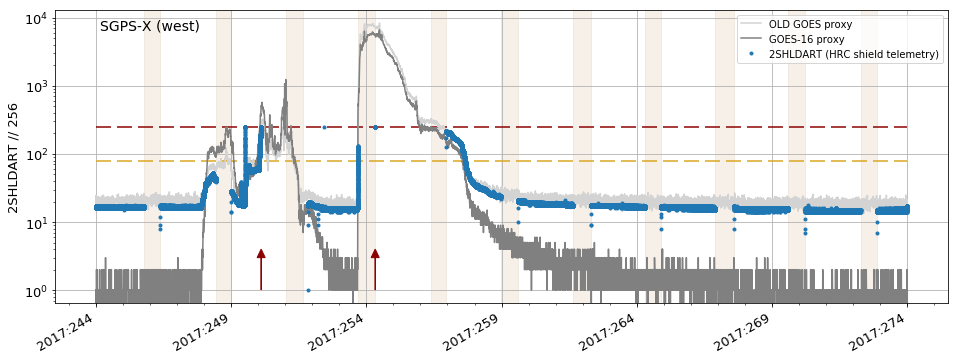

In [17]:
hrcproxy_correction = 0
plt.figure(figsize=[16, 6])
# Note: Scaling by 256 implemented inside the plotting routine
plot_old_new_proxy(k, arc2017_flt, HRCProxy_2017, hrcproxy_correction, shld2017)
ax = plt.gca()

for rad_zone in rad_zones:
    x1 = DateTime(rad_zone['start']).plotdate
    x2 = DateTime(rad_zone['stop']).plotdate
    ax.axvspan(x1, x2, alpha=0.2, color='tan')

for scs107 in scs107s:
    plt.arrow(DateTime(scs107['start']).plotdate, 1, 0, 2,
              head_width=0.3, head_length=1, color='darkred')

__Figure:__ Chandra's HRC shield rate telemetry __(blue)__ and its proxies: __(light gray)__ computed using the OLD GOES data and __(dark gray)__ computed using the GOES-16 data. __The same old coefficients used for both proxies.__ The yellow dashed line marks MTA's yellow alert limit. The red dashed line marks 250 counts/sample at which RADMON will trigger SCS 107 (SI safing action). The red arrows mark the two instances of SCS 107 run over the considered time period. Shaded areas mark radiation zones. As expected, the difference in bgd level between the two generations of the GOES satellites translates into the difference in the noise level of HRC proxies. This can be interpreted as a signature of the bgd level difference between the HRC and GOES-16, indicating a need of a 4th additive parameter in the HRC proxy equation.

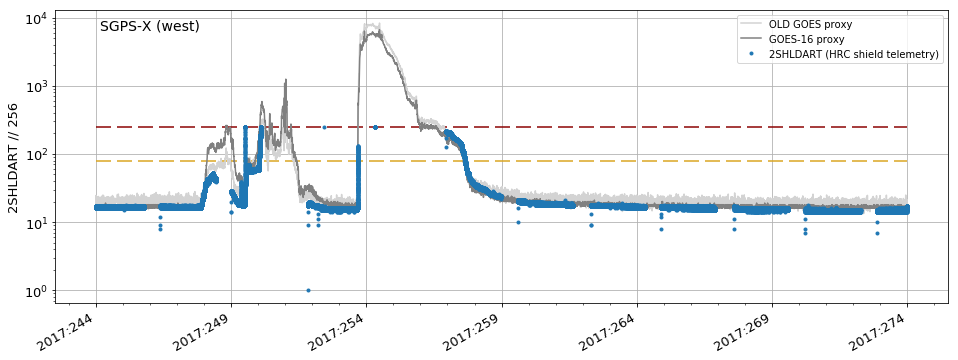

In [18]:
hrcproxy_correction = 16

plt.figure(figsize=[16, 6])
plot_old_new_proxy(k, arc2017_flt, HRCProxy_2017, hrcproxy_correction, shld2017)

__Figure:__ The same as in the cell above but GOES-16 HRC proxy contains an arbitrary additive term, hrcproxy_correction = 16.

## HRC shield rate model derived from the Sept. 2017 GOES-16 data

In order to fit a new model, the 2SHLDART telemetry and GOES-16 proton data need to be interpolated onto the same time axis. The telemetry is sampled every ~8 secs while the GOES-16 data is sampled every 5 min. The HRC shield rate telemetry will be interpolated onto the time axis of the GOES-16 data, even though this will mean discarding a significant fraction of the "observations" (the other option, i.e. interpolating the GOES-16 data onto the time axis of HRC shield rate telemetry would introduce "fake" data and could bias the model). Time intervals corresponding to radiation zone passages, radiation shutdowns, and HRC shield rate saturation (> 248 * 256) will be removed prior to interpolating.

In [19]:
ok1 = shld2017.vals == 255  # radzones
ok2 = shld2017.vals > 248 * 256  # HRC shield rate ``saturation``
ok3 = ok1 | ok2

In [20]:
# Sampling of HRC shield rate telemetry
deltas_t = shld2017.times[ok3][1:] - shld2017.times[ok3][:-1]
deltas_t[:4]

array([ 8.20000041,  8.20000052,  8.20000052,  8.20000041])

In [21]:
ok4 = deltas_t > 8.21  # gaps due to radiation shutdown

In [22]:
# Start and stop times of gaps due to radzones, saturation or radiation shutdowns
gap_tstart = np.insert(shld2017.times[ok3][1:][ok4], 0, shld2017.times[ok1][0])
gap_tstop = np.append(shld2017.times[ok3][:-1][ok4], shld2017.times[ok1][-1])

In [23]:
pad = 30

In [24]:
# Filter the GOES-16 proton data, introduce data gaps as in the HRC shield rate telemetry
okg = np.ones(len(TimeStamp), dtype=bool)
for t1, t2 in zip(gap_tstart, gap_tstop):
    ok = (TimeStamp > t1 - pad) & (TimeStamp < t2 + pad)
    okg = okg & ~ok

In [25]:
# Interpolate 2SHLDART data on GOES-16 time axis with matching gaps.
# Note: GOES-16 data are sampled every 5 min, 2SHLDART data are sampled
# every ~8 sec, so this way we are discarding some good 2SHLDART data
# but not `inventing` any GOES-16 data as would be the case of we
# interpolated the GOES-16 data on the 2SHLDART time axis
shld2017_intrpl = interpolate(shld2017.vals, shld2017.times, TimeStamp[okg])

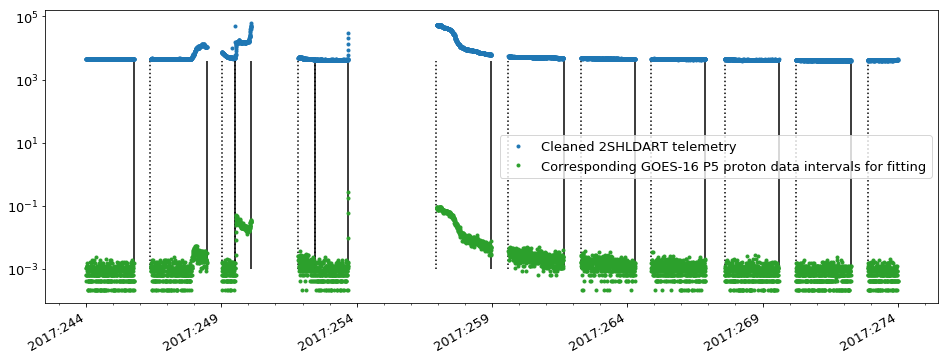

In [26]:
plt.figure(figsize=(16, 6))
plot_cxctime(TimeStamp[okg], shld2017_intrpl,
             color='C0', ls='None', marker='.', label='Cleaned 2SHLDART telemetry')
plt.vlines(DateTime(gap_tstart).plotdate, 1e-3, 4000, linestyle='-')
plt.vlines(DateTime(gap_tstop).plotdate, 1e-3, 4000, linestyle=':')
plot_cxctime(TimeStamp[okg], ProtonFluxes[:, k, 7][okg],
             ls='None', marker='.', color='C2',
             label='Corresponding GOES-16 P5 proton data intervals for fitting')
plt.legend()
plt.yscale('log');

__FIgure:__ Cleaned 2SHLDART telemetry (removed gaps due to radzones, telemetry saturation and radiation shutdowns), and corresponding GOES-16 proton data intervals that will be used to derive the new model.

In [27]:
# Fitting functions

def hrc_shield_proxy(pars, proton_fluxes):
    if len(pars) == 3:
        # OLD HRC proxy model
        c0, c1, c2 = pars
        return c0 * proton_fluxes[0] + c1 * proton_fluxes[1] + c2 * proton_fluxes[2]   
    elif len(pars) == 4:
        # NEW HRC proxy model
        c0, c1, c2, c3 = pars
        return c0 * proton_fluxes[0] + c1 * proton_fluxes[1] + c2 * proton_fluxes[2] + c3


def hrc_shield_proxy_model(proton_fluxes):
    
    def sherpa_func(pars, x=None):
        return hrc_shield_proxy(pars, proton_fluxes)
    
    return sherpa_func


def fit_hrc_proxy(times, vals, nn, idx0, idx1):
    data_id = 1
    comp_names = [f'c{i}' for i in range(nn)]
    ui.set_method('simplex')
    ui.set_stat('cstat')

    proton_fluxes = []
    for key in CHANS_G16_PROXY.keys():
        proton_fluxes.append(ProtonFluxes[:, k, key][okg][idx0:idx1])
    
    ui.load_user_model(hrc_shield_proxy_model(proton_fluxes), 'model')
        
    ui.add_user_pars('model', comp_names)
    ui.set_model(data_id, 'model')
    ui.load_arrays(data_id,
                   np.array(times[idx0:idx1]),
                   np.array(vals[idx0:idx1]))

    # Initial fit values
    fmod = ui.get_model_component('model')
    for i in range(nn):
        comp_name = f'c{i}'
        setattr(fmod, comp_name, pars0[i])
        comp = getattr(fmod, comp_name)
        comp.max = 3e7
        comp.min = 0
        
    for i in range(10):
        ui.fit(data_id)

    ui.set_conf_opt('max_rstat', 250)
    ui.set_conf_opt('sigma', 1)
    ui.conf()
    conf = ui.get_confidence_results()
    return ui.get_fit_results(), conf


def get_model_min_max(res, conf, proton_fluxes):
    model = hrc_shield_proxy(res.parvals, proton_fluxes)
    
    parmins = list(conf.parmins)
    for ii, parmin in enumerate(parmins):
        if parmin is None:
            parmins[ii] = res.parvals[ii]
    
    vals_min = np.array(res.parvals) + np.array(parmins)
    vals_max = np.array(res.parvals) + np.array(conf.parmaxes)
    model_min = hrc_shield_proxy(vals_min, proton_fluxes)
    model_max = hrc_shield_proxy(vals_max, proton_fluxes)
    return model, model_min, model_max

In [28]:
idx_start = 0
idx_end = len(shld2017_intrpl)
idx_half = 1800

In [29]:
# Fit not normalized telemetry
pars0 = [AA, BB, CC, 4000]
nn = len(pars0)
res00, conf00 = fit_hrc_proxy(TimeStamp[okg], shld2017_intrpl, nn, idx_start, idx_end)

Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 5.13668e+06
Final fit statistic   = 872132 at function evaluation 4087
Data points           = 5765
Degrees of freedom    = 5761
Probability [Q-value] = 0
Reduced statistic     = 151.385
Change in statistic   = 4.26455e+06
   model.c0       1324.41     
   model.c1       511018      
   model.c2       1469.11     
   model.c3       3832        
Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 872132
Final fit statistic   = 868859 at function evaluation 4087
Data points           = 5765
Degrees of freedom    = 5761
Probability [Q-value] = 0
Reduced statistic     = 150.817
Change in statistic   = 3272.86
   model.c0       1331.38     
   model.c1       508639      
   model.c2       0.00449353  
   model.c3       3836.86     
Dataset               = 1
Method                = neldermead
Statistic             = 

In [30]:
# OLD coefficients
AA, BB, CC

(6000, 270000, 100000)

In [31]:
# Fit not normalized telemetry
# Fit initial flares, predict the main flare
pars0 = [AA, BB, CC, 4000]
nn = len(pars0)
res01, conf01 = fit_hrc_proxy(TimeStamp[okg], shld2017_intrpl, nn, idx_start, idx_half)

Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 4.36062e+06
Final fit statistic   = 372840 at function evaluation 4087
Data points           = 1800
Degrees of freedom    = 1796
Probability [Q-value] = 0
Reduced statistic     = 207.594
Change in statistic   = 3.98778e+06
   model.c0       1410.23     
   model.c1       368031      
   model.c2       0.0314101   
   model.c3       4077.18     
Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 372840
Final fit statistic   = 372840 at function evaluation 4087
Data points           = 1800
Degrees of freedom    = 1796
Probability [Q-value] = 0
Reduced statistic     = 207.594
Change in statistic   = 0.136889
   model.c0       1409.63     
   model.c1       368033      
   model.c2       0.103756    
   model.c3       4077.23     
Dataset               = 1
Method                = neldermead
Statistic             =

In [32]:
# Fit not normalized telemetry
# Fit the main flare, predict the initial flares
pars0 = [AA, BB, CC, 4000]
nn = len(pars0)
res02, conf02 = fit_hrc_proxy(TimeStamp[okg], shld2017_intrpl, nn, idx_half + 100, idx_end)

Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 771209
Final fit statistic   = 198326 at function evaluation 993
Data points           = 3865
Degrees of freedom    = 3861
Probability [Q-value] = 0
Reduced statistic     = 51.3664
Change in statistic   = 572884
   model.c0       10953.9     
   model.c1       257936      
   model.c2       0.00253155  
   model.c3       3942.03     
Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 198326
Final fit statistic   = 198043 at function evaluation 404
Data points           = 3865
Degrees of freedom    = 3861
Probability [Q-value] = 0
Reduced statistic     = 51.2932
Change in statistic   = 282.558
   model.c0       11300.7     
   model.c1       247150      
   model.c2       0.00720072  
   model.c3       3950.68     
Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initia

In [33]:
# Fit not normalized telemetry with a 3-param model
# Not a good fit, reduced statistic > 3000
#pars0 = [AA, BB, CC]
#nn = len(pars0)
#res1, conf1 = fit_hrc_proxy(TimeStamp[okg], shld2017_intrpl, nn, idx_start, idx_end)

In [34]:
# Fit normalized telemetry
# To demonstrate consistency with res00, conf00 (fit to not normalized telemetry).
# Resulting coefficients are of the order of res00.parvals * 256.
pars0 = [AA, BB, CC, 16]
nn = len(pars0)
res2, conf2 = fit_hrc_proxy(TimeStamp[okg], shld2017_intrpl // 256, nn, idx_start, idx_end)

Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 3.69347e+07
Final fit statistic   = 7.41261e+06 at function evaluation 4087
Data points           = 5765
Degrees of freedom    = 5761
Probability [Q-value] = 0
Reduced statistic     = 1286.69
Change in statistic   = 2.95221e+07
   model.c0       1233.36     
   model.c1       0.0293362   
   model.c2       4.8696e-05  
   model.c3       352.254     
Dataset               = 1
Method                = neldermead
Statistic             = cstat
Initial fit statistic = 7.41261e+06
Final fit statistic   = 3475.57 at function evaluation 4086
Data points           = 5765
Degrees of freedom    = 5761
Probability [Q-value] = 1
Reduced statistic     = 0.603292
Change in statistic   = 7.40914e+06
   model.c0       5.20426     
   model.c1       1992        
   model.c2       0.000113085 
   model.c3       14.1809     
Dataset               = 1
Method                = neldermead
Statisti

__NOTE:__ Compared to the old proxy coefficients, in the new model the dependence on the highest energy channel becomes very weak: c2 consistent with zero in all fits, probably because the noise is modeled explicitly and/or the 2017 flare was rather soft. Future flaring episodes will allow to determine if the dependence of the P8A channel needs to beincluded in the proxy model.

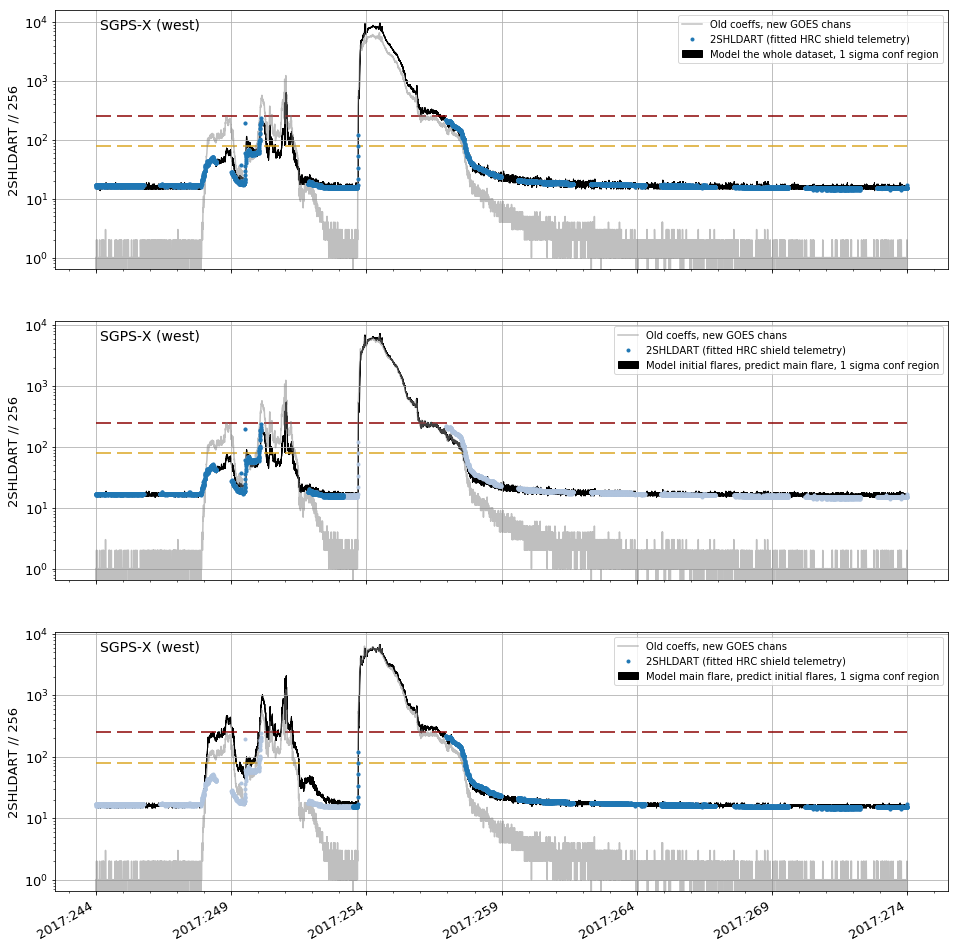

In [35]:
plt.figure(figsize=[16, 18])
plt.subplot(3, 1, 1)
plot_fit_results(res00, conf00, proton_fluxes, idx_start, idx_end,
                 label='Model the whole dataset')
plt.subplot(3, 1, 2)
plot_fit_results(res01, conf01, proton_fluxes, idx_start, idx_half,
                 label='Model initial flares, predict main flare')
plt.subplot(3, 1, 3)
plot_fit_results(res02, conf02, proton_fluxes, idx_half + 100, idx_end,
                 label='Model main flare, predict initial flares')

__Top:__ The HRC shield rate telemetry (dark blue) and the new HRC proxy model (black) compared with the HRC proxy derived using the old coefficients and new GOES-16 channels (gray). The model accounts well for the telemetry at the time of the initial flaring and at the time of the main flare. __Middle:__ Model was derived using the telemetry at the time of the initial flaring (dark blue) and extrapolated to predict the HRC shield rate past day 253 (light blue). The model predicts relatively well the HRC telemetry coinciding with the rise and decay of the main flare. __Bottom:__ Model was derived using the telemetry at the time of the main flare (dark blue) and extrapolated to predict the HRC shield rate prior to day ~253 (light blue). The model overpredicts the HRC shield rate at the time of the initial flaring, days 248-249 and 252.

### Application of the model to the December 2020 C-class flare data

In [36]:
# Dec 2020, C/M-class flare
# Removed intervals corresponding to rad zone passages
# with 30 sec (~3 samples) padding on each end
shld2020 = fetch.Msid('2shldbrt', start='2020:329', stop='2020:354')
interval_pad = 30 # secs
events.rad_zones.interval_pad = (interval_pad, interval_pad)
shld2020.remove_intervals(events.rad_zones)

In [37]:
# HRC proxy at the time of the C/M Dec 2020 class flare
# using old coefficients on new G16 channels
proton_fluxes_2020 = [arc_goes['p5'][arc2020_flt],
                      arc_goes['p7'][arc2020_flt],
                      arc_goes['p8a'][arc2020_flt]]
HRCProxy_Cflare = calc_HRCProxy(proton_fluxes_2020)

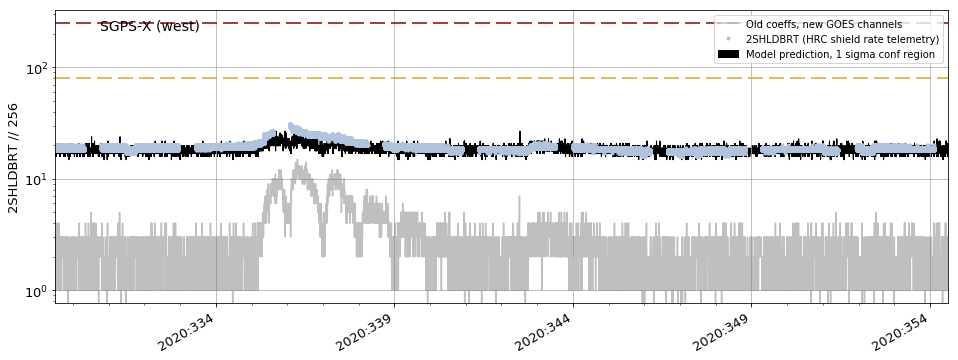

In [38]:
plt.figure(figsize=[16, 6])

# Old coefficients, new GOES channels
plot_cxctime(arc_goes['secs'][arc2020_flt], HRCProxy_Cflare // 256,
             color='gray', label="Old coeffs, new GOES channels", alpha=0.5)

x1 = DateTime('2020:329').plotdate
x2 = DateTime('2020:354').plotdate
plt.xlim([x1, x2])
ax = plt.gca()

# HRC shield rate, model fitted to the complete Sept. 2017 dataset
model, model_min, model_max = get_model_min_max(res00, conf00, proton_fluxes_2020)
ax.fill_between(DateTime(arc_goes['secs'][arc2020_flt]).plotdate,
                model_max // 256, model_min // 256,
                color='k', label='Model prediction, 1 sigma conf region')

plot_cxctime(shld2020.times, shld2020.vals // 256,
             color='lightsteelblue', marker='.', ls='None',
             label="2SHLDBRT (HRC shield rate telemetry)")

plt.hlines([250], x1, x2, color='darkred', linestyle=(0, (10, 4)))
plt.hlines([80], x1, x2, color='goldenrod', linestyle=(0, (10, 4)))
plot_format(ax, k)
plt.ylabel('2SHLDBRT // 256');

__Figure:__ GOES-16 HRC proxy (linear combination of GOES-16 channels with old coefficients, __gray__) and the prediction of the new 4-parameter HRC shield rate model __(black)__ compared with the Chandra telemetry at the time of the December 2020 C-class flare __(blue)__.

## Ratio of NEW to OLD proxy vs proton flux

In [39]:
# Interpolate arc (Replan Central) HRC shield rate proxy
# Replan Central proxy includes // 256
# on the time axis of the NOAA G16 data
yout = interpolate(arc_goes['hrc_shield'][arc2017_flt], arc_goes['secs'][arc2017_flt], TimeStamp)

In [40]:
proxy_ratio = (HRCProxy_2017 // 256) / yout

In [41]:
hrcproxy_correction = 16
proxy_ratio_bgd_corrected = (HRCProxy_2017 // 256 + hrcproxy_correction) / yout

In [42]:
proxy_ratio_new_fit = (hrc_shield_proxy(res00.parvals, proton_fluxes) // 256) / yout

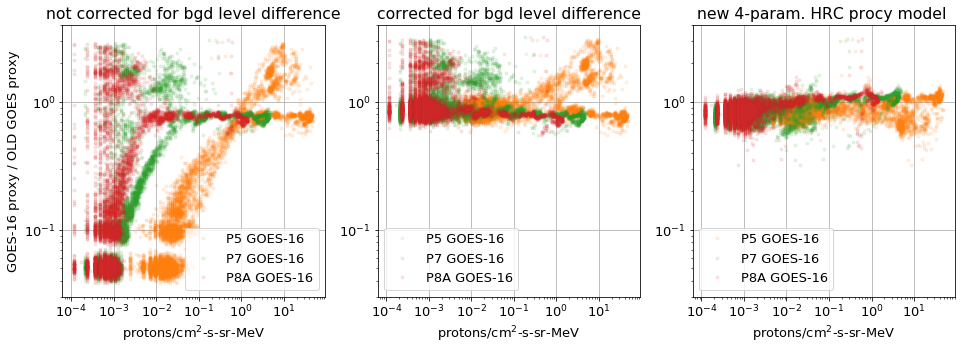

In [43]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plot_proxy_ratio(proxy_ratio, 'not corrected for bgd level difference')

plt.subplot(1, 3, 2)
plot_proxy_ratio(proxy_ratio_bgd_corrected, 'corrected for bgd level difference')
plt.ylabel('')

plt.subplot(1, 3, 3)
plot_proxy_ratio(proxy_ratio_new_fit, 'new 4-param. HRC procy model ')
plt.ylabel('');

__Figure:__ The apparent dependence of the proxy ratio on proton flux appears to be due to the difference in the backgorund level between the old and new generation of GOES satellites.